In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
import matplotlib.image as mp_image
import matplotlib.pyplot as plt
import numpy as np
import random as rd
from PIL import Image, ImageOps
from numba import jit
from numba import njit



Dimensões da Imagem N: 3

Dimensões da Imagem G: 3

Dimensões da Imagem O: 3

Shape da Imagem N: (280, 300, 3)

Shape da Imagem G: (396, 312, 3)

Shape da Imagem O: (499, 327, 3)


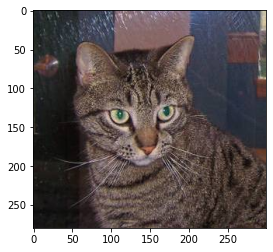

In [138]:
filename1 = "../../training_set/training_set/cats/cat.1.jpg"
filename2 = "../../training_set/training_set/cats/cat.2.jpg"
filename3 = "../../training_set/training_set/dogs/dog.1.jpg"
nermal_img = Image.open(filename1)
nermal = np.array(nermal_img)

garfield_img = Image.open(filename2)
garfield = np.array(garfield_img)

odie_img = Image.open(filename3)
odie = np.array(odie_img)

# Dimensão
print ('\nDimensões da Imagem N: {}'.format(nermal.ndim))
print ('\nDimensões da Imagem G: {}'.format(garfield.ndim))
print ('\nDimensões da Imagem O: {}'.format(odie.ndim))

# Shape
print ('\nShape da Imagem N: {}'.format(nermal.shape))
print ('\nShape da Imagem G: {}'.format(garfield.shape))
print ('\nShape da Imagem O: {}'.format(odie.shape))

# Imprime a imagem
plt.imshow(nermal_img)
plt.show()


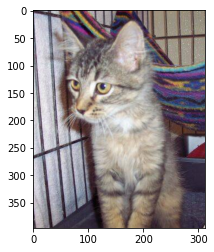

In [62]:
plt.imshow(garfield_img)

In [ ]:
def aug_img(image, nm_samples=32):
    samples = [image]
    samples.append(ImageOps.flip(image))
    samples.append(ImageOps.mirror(image))
    for i in range(nm_samples-3):
        samples.append(image.rotate(round(nm_samples/(i+1))))
    return samples



In [ ]:
images = aug_img(nermal_img)
nermal_augm = []
for img in images:
    nermal_augm.append(np.array(img).reshape(nermal.shape[0]*nermal.shape[1]*nermal.shape[2])/255)

len(nermal_augm)
nermal_array = np.array(nermal_augm)
print(nermal_array.shape)
nermal_array[0,0:10]

In [ ]:
nermal_flt = tf.Variable(tf.reshape(nermal_array, shape = (nermal.shape[0]*nermal.shape[1]*nermal.shape[2], -1)), dtype=tf.dtypes.float64)
nermal_flt.shape

In [ ]:
nermal_encode = tf.zeros((32, 2048),dtype=tf.dtypes.float64).numpy()
cat_encode = tf.zeros((32, 2048),dtype=tf.dtypes.float64).numpy()
nermal_encode

In [ ]:
count = 0
cat_cols = [rd.randint(0, 2047) for _ in range(40)]
while len(set(cat_cols)) != 40 or count < 10:
    cat_cols = [rd.randint(0, 2047) for _ in range(40)]
    count += 1

len(set(cat_cols))


In [ ]:
nermal_ref = {}
for i in cat_cols:
    nermal_ref[i] = rd.randint(0, 31)


In [ ]:
for i in cat_cols:
    cat_encode[:,i] = 1.
    nermal_encode[nermal_ref[i],i] = 1.


In [ ]:
w = tf.Variable(tf.random.normal(shape=(128, nermal.shape[0]*nermal.shape[1]*nermal.shape[2]), dtype=tf.dtypes.float64))
print(w[0:10,0])
print(w.shape)
bias = tf.Variable(tf.random.normal(shape=(128, 1), dtype=tf.dtypes.float64))
bias[0:10]

In [ ]:
print(w.shape)
print(nermal_flt.shape)


In [ ]:
wXa = tf.linalg.matmul(w, nermal_flt)
beta = tf.keras.activations.sigmoid(wXa + bias)
beta.shape

In [ ]:
print(beta.shape)
print(nermal_encode.shape)
# HxB = T : B = WxA + b
# H = B'T
# Hx[wxN * NxM = wxM]
# Hx[wxN * Nx32 = wx32] = 32x2048
# [2048xw]x[wx32] = 2048x32

In [ ]:
inv_beta = np.linalg.pinv(beta)
inv_beta.shape


In [ ]:
print(nermal_encode.shape)
print(inv_beta.shape)


In [ ]:
H = tf.linalg.matmul(nermal_encode.T, inv_beta)
H.shape


In [ ]:
nermal_out = tf.linalg.matmul(H, beta)
nermal_out.shape


In [ ]:
@jit(nopython=True)
def thr_sig(x, trh=0.5):
    if x >= trh:
        return 1.
    else:
        return 0.
    

In [ ]:
count = 0
for i in range(0, nermal_out.shape[0]):
    for j in range(0, nermal_out.shape[1]):
        if thr_sig(nermal_out[i,j].numpy(), 0.9) != nermal_encode[j,i]:
            print(f"Inv: {i},{j}")
        elif nermal_encode[j,i] == 1:
            print(i, j, nermal_out[i,j])
            count += 1

print(count)


In [ ]:
def calc_H_elm(weight, bias, activation_fun, encode_matrix, data):
    wXd = tf.linalg.matmul(weight, data)
    beta = activation_fun(wXd + bias)
    invbeta = np.linalg.pinv(beta)
    H = tf.linalg.matmul(encode_matrix.T, invbeta)
    return H, beta


In [ ]:
@jit(nopython=True)
def boost_input(encode_matrix, tr=0.5):
    for i in range(encode_matrix.shape[0]):
        for j in range(encode_matrix.shape[1]):
            encode_matrix[i,j] = thr_sig(encode_matrix[i,j], tr)
    return encode_matrix


In [ ]:
nermal_out_boosted = boost_input(nermal_out.numpy())


In [ ]:
count = 0
for i in range(0, nermal_out_boosted.shape[0]):
    for j in range(0, nermal_out_boosted.shape[1]):
        if nermal_encode[j,i] == 1:
            print(i, j, nermal_out_boosted[i,j])
            count += 1

print(count)


nermal_out_boosted = nermal_out_boosted.reshape(-1, nermal_out_boosted.shape[0]*nermal_out_boosted.shape[1])
nermal_out_boosted.shape

nermal_out_boosted_mx = []
for i in range(32):
    nermal_out_boosted_mx.append(nermal_out_boosted[0])
    
nermal_input = np.array(nermal_out_boosted_mx).T
nermal_input.shape


In [ ]:
wcat = tf.Variable(tf.random.normal(shape=(128, nermal_out_boosted.shape[0]), dtype=tf.dtypes.float64))
print(wcat.shape)
biascat = tf.Variable(tf.random.normal(shape=(128, 1), dtype=tf.dtypes.float64))
biascat.shape

In [ ]:
HCat, betaCat = calc_H_elm(weight=wcat, bias=biascat, activation_fun=tf.keras.activations.sigmoid, encode_matrix=cat_encode, data=nermal_out_boosted)
HCat.shape

In [ ]:
cat_out = tf.linalg.matmul(H, beta).numpy()
cat_out.shape

In [ ]:
count = 0
for i in range(0, cat_out.shape[0]):
    if np.mean(cat_out[i,:]) > 0:
        print(i, np.mean(cat_out[i,:]))
        count += 1

print(count)


In [ ]:
cat_out_b = boost_input(cat_out, 0.02)
count = 0
for i in range(0, cat_out_b.shape[0]):
    if np.mean(cat_out_b[i,:]) > 0:
        #print(i, np.mean(cat_out_b[i,:]))
        print(i, cat_out_b[i,:])
        count += 1

print(count)


In [ ]:
for i in cat_cols:
    print(cat_encode[:,i])
    

In [149]:
class ElementEncoded:
    def __init__(self, data, shape_weights=None, shape_output=None, activation_fun=None, set_all_columns=True, nm_cols_sets=None, lst_cols_set=None, output=None, name=None):
        self.encode_ref = None
        if shape_output == None:
            if output == None:
                self.shape_output = (32,2048)
            else:
                self.shape_output = output.shape
        else:
            self.shape_output = shape_output
            
        self.encode_output = np.zeros(shape=self.shape_output)
        
        if nm_cols_sets == None:
            self.nm_cols_sets = 40
        else:
            self.nm_cols_sets = nm_cols_sets
            
        if activation_fun == None:
            self.activation_function = self.default_activation_fun_sigmoid
        else:
            self.activation_function = activation_fun
            
        if shape_weights == None:
            self.weights = np.random.rand(128, data.shape[0])
            self.bias = np.random.rand(128, 1)
        else:
            self.weights = np.random.rand(shape_weights[0], shape_weights[1])
            self.bias = np.random.rand(shape_weights[0], 1)
        
        if output == None:
            # Create encode
            self.encode_output, self.encode_ref, self.lst_cols_set = self.create_encode(lst_cols_set, self.shape_output, self.nm_cols_sets, set_all_columns)
        else:
            self.encode_output = output
            
        
        # Calc H and beta to this encode
        self.H, self.beta = self.calc_H_elm(self.weights, self.bias, self.activation_function, self.encode_output, data)
    
    @classmethod
    def create_encode(self, lst_cols=None, shape_output=(32, 2048), nm_cols_sets=40, set_all_columns=True):
        encode_ref = {}
        encode_output = np.zeros(shape=shape_output)
        if lst_cols == None:
            lst_cols_set = self.rand_cols(0, shape_output[1]-1, nm_cols_sets)
        else:
            lst_cols_set = lst_cols

        lst_cols_set.sort()
        
        if set_all_columns:
            for i in lst_cols_set:
                encode_output[:,i] = 1.
        else:
            for i in lst_cols_set:
                encode_ref[i] = rd.randint(0, shape_output[0]-1)
                encode_output[encode_ref[i],i] = 1.
        return encode_output, encode_ref, lst_cols_set
    
    @classmethod
    def calc_H_elm(self, weights, bias, activation_fun, encode_matrix, data):
        wXd = np.matmul(weights, data)
        beta = activation_fun(wXd + bias)
        invbeta = np.linalg.pinv(beta)
        H = np.matmul(encode_matrix.T, invbeta)
        return H, beta
    
    def default_activation_fun_sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    @classmethod
    def rand_cols(self, start, end, num_cols, max_tries=100):
        for i in range(max_tries):
            lst = [rd.randint(start, end) for _ in range(num_cols)]
            if len(set(lst)) == num_cols:
                return lst
        return lst
    
    def return_output_from_H(self):
        return np.matmul(self.H, self.beta).T

    def return_output_boosted_from_H(self):
        return self.boost_output(np.matmul(self.H, self.beta).T)
    
    def predict(self, data_pred):
        wXd = np.matmul(self.weights, data_pred)
        beta = self.activation_function(wXd + self.bias)
        return np.matmul(self.H, beta).T
    
    def predict_boosted(self, data_pred, tr=0.5):
        encode_matrix = self.predict(data_pred)
        return self.boost_output(encode_matrix, tr=tr)
    
    def boost_output(self, encode_matrix, tr=0.5):
        for i in range(encode_matrix.shape[0]):
            for j in range(encode_matrix.shape[1]):
                encode_matrix[i,j] = self.thr_sig(encode_matrix[i,j], tr)
        return encode_matrix

    def thr_sig(self, x, trh=0.5):
        if x >= trh:
            return 1.
        else:
            return 0.
    
    def verify_encode(self, encode_matrix, tr=0.9):
        if encode_matrix.shape != self.encode_output.shape:
            return None
        
        for i in range(encode_matrix.shape[0]):
            stats = {"lst_cols_set":[], "invalid_lst":[], "nm_cols_set":0}
            for j in range(encode_matrix.shape[1]):
                if self.thr_sig(encode_matrix[i,j], tr) != self.encode_output[i,j]:
                    stats["invalid_lst"].append((i,j))
                elif self.encode_output[i,j] == 1:
                    stats["lst_cols_set"].append((i, j, encode_matrix[i,j], np.mean(encode_matrix[:,j]), np.sum(encode_matrix[:,j])))
                    stats["nm_cols_set"] += 1    
        return stats
                    

class Eye:
    
    def __init__(self, filename, size=(200, 200)):
        self.filename = filename
        self.image = Image.open(filename)
        self.size = size
        
    @classmethod
    def aug_image(self, image, nm_samples=32):
        samples = [self.flat(image)]
        samples.append(self.flat(ImageOps.flip(image)))
        samples.append(self.flat(ImageOps.mirror(image)))
        for i in range(nm_samples-3):
            samples.append(self.flat(image.rotate(round(nm_samples/(i+1)))))
        return np.array(samples).T
    
    def see_image(self, nm_samples=32):
        #resize = self.image
        #resize.thumbnail(self.size, Image.ANTIALIAS)
        fit = ImageOps.fit(self.image, self.size, Image.ANTIALIAS)
        return self.aug_image(fit, nm_samples)
    
    @classmethod
    def flat(self, image):
        arr = np.array(image)
        return arr.reshape(arr.shape[0]*arr.shape[1]*arr.shape[2])/255


In [98]:
cat_encode = ElementEncoded.create_encode(nm_cols_sets=40, set_all_columns=True)
nermal_encode_inhibitor = ElementEncoded.create_encode(nm_cols_sets=40, lst_cols=cat_encode[2], set_all_columns=False)


In [99]:
print(cat_encode[2][0])
print(cat_encode[0][:,cat_encode[2][0]])
print(nermal_encode_inhibitor[2][0])
nermal_encode_inhibitor[0][:,nermal_encode_inhibitor[2][0]]


17
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]
17


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [114]:
nermal_teste = Eye(filename1)
nermal_data = nermal_teste.see_image()
print(nermal_data.shape)


(120000, 32)


In [158]:
nermal = ElementEncoded(data=nermal_data, shape_weights=(128, nermal_data.shape[0]), lst_cols_set=cat_encode[2], set_all_columns=False)


In [159]:
print(cat_encode[2][0])
print(nermal.encode_output[:, cat_encode[2][0]])
nermal.encode_output[:, cat_encode[2][0]-1]


17
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0.]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [117]:
np.multiply(nermal_encode_inhibitor[0], nermal.encode_output)[:, cat_encode[2][0]]


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [160]:
teste = nermal.return_output_from_H()


In [161]:
print(teste[:, cat_encode[2][0]-1])
teste[:, cat_encode[2][0]]


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


array([0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125])

In [162]:
np.multiply(nermal_encode_inhibitor[0], teste)[:, cat_encode[2][0]]


array([0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.03125, 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     ])

In [163]:
garfield_teste = Eye(filename2)
garfield_data = garfield_teste.see_image()
print(garfield_data.shape)


(120000, 32)


In [164]:
garfield_pred = nermal.predict(garfield_data)


In [165]:
np.mean(garfield_pred[:, cat_encode[2][:]], axis=0)


array([0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125])

In [166]:
odie_teste = Eye(filename2)
odie_data = odie_teste.see_image()
print(odie_data.shape)


(120000, 32)


In [167]:
odie_pred = nermal.predict(odie_data)


In [168]:
np.mean(odie_pred[:, cat_encode[2][:]], axis=0)


array([0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125, 0.03125,
       0.03125, 0.03125, 0.03125, 0.03125, 0.03125])

In [169]:
nermal.verify_encode(odie_pred)


{'lst_cols_set': [], 'invalid_lst': [(31, 1914)], 'nm_cols_set': 0}